In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2025-05-21 15:18:55.106699: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 15:18:55.268583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747820935.351600    5223 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747820935.375121    5223 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747820935.508407    5223 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50

In [3]:
import os
from PIL import Image

bad_files = []
for root, _, files in os.walk("PlantVillage"):
    for f in files:
        try:
            img_path = os.path.join(root, f)
            Image.open(img_path).verify()  # Verifies image integrity
        except:
            bad_files.append(img_path)

print("Corrupted/unsupported files:", bad_files)


Corrupted/unsupported files: []


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


I0000 00:00:1747820948.172265    5223 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

2025-05-21 15:19:20.181383: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


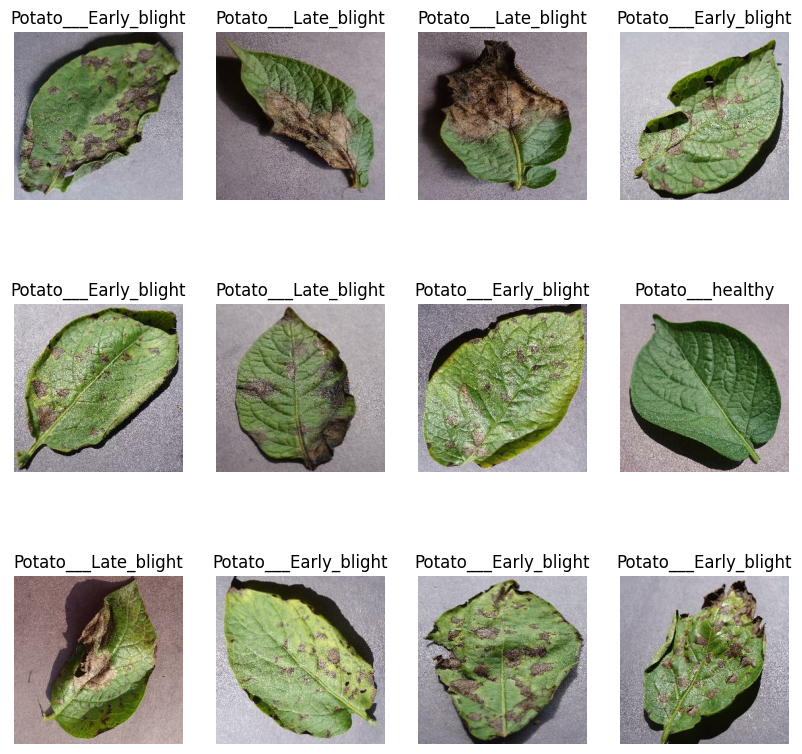

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [14]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])


In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  
n_classes = 3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)


/home/valmiki-uday-kiran/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses. SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


I0000 00:00:1747821070.232854    5313 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.4534 - loss: 0.9282 - val_accuracy: 0.5990 - val_loss: 0.9098
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.7361 - loss: 0.5880 - val_accuracy: 0.7552 - val_loss: 0.5162
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.8972 - loss: 0.2769 - val_accuracy: 0.9010 - val_loss: 0.2859
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9176 - loss: 0.2175 - val_accuracy: 0.8229 - val_loss: 0.4520
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9025 - loss: 0.2268 - val_accuracy: 0.9219 - val_loss: 0.2124
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9329 - loss: 0.1647 - val_accuracy: 0.8854 - val_loss: 0.2583
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9459 - loss: 0.1501 - val_accuracy: 0.9271 - val_loss: 0.1714
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9404 - loss: 0.1475 - val_accuracy: 0.9167 - val_loss: 

In [28]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9798 - loss: 0.0393


In [29]:
scores

[0.046550244092941284, 0.9765625]

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
predicted label: Potato___Late_blight


2025-05-21 15:27:45.691457: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


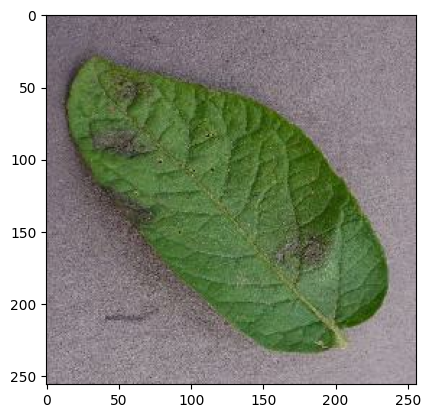

In [30]:
import numpy as np
np.argmax([9.9999964e-01,3.9333537e-07,1.1586251e-18])
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [31]:
def predict(model, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array= tf.expand_dims(img_array,0)
    predictions= model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence= round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


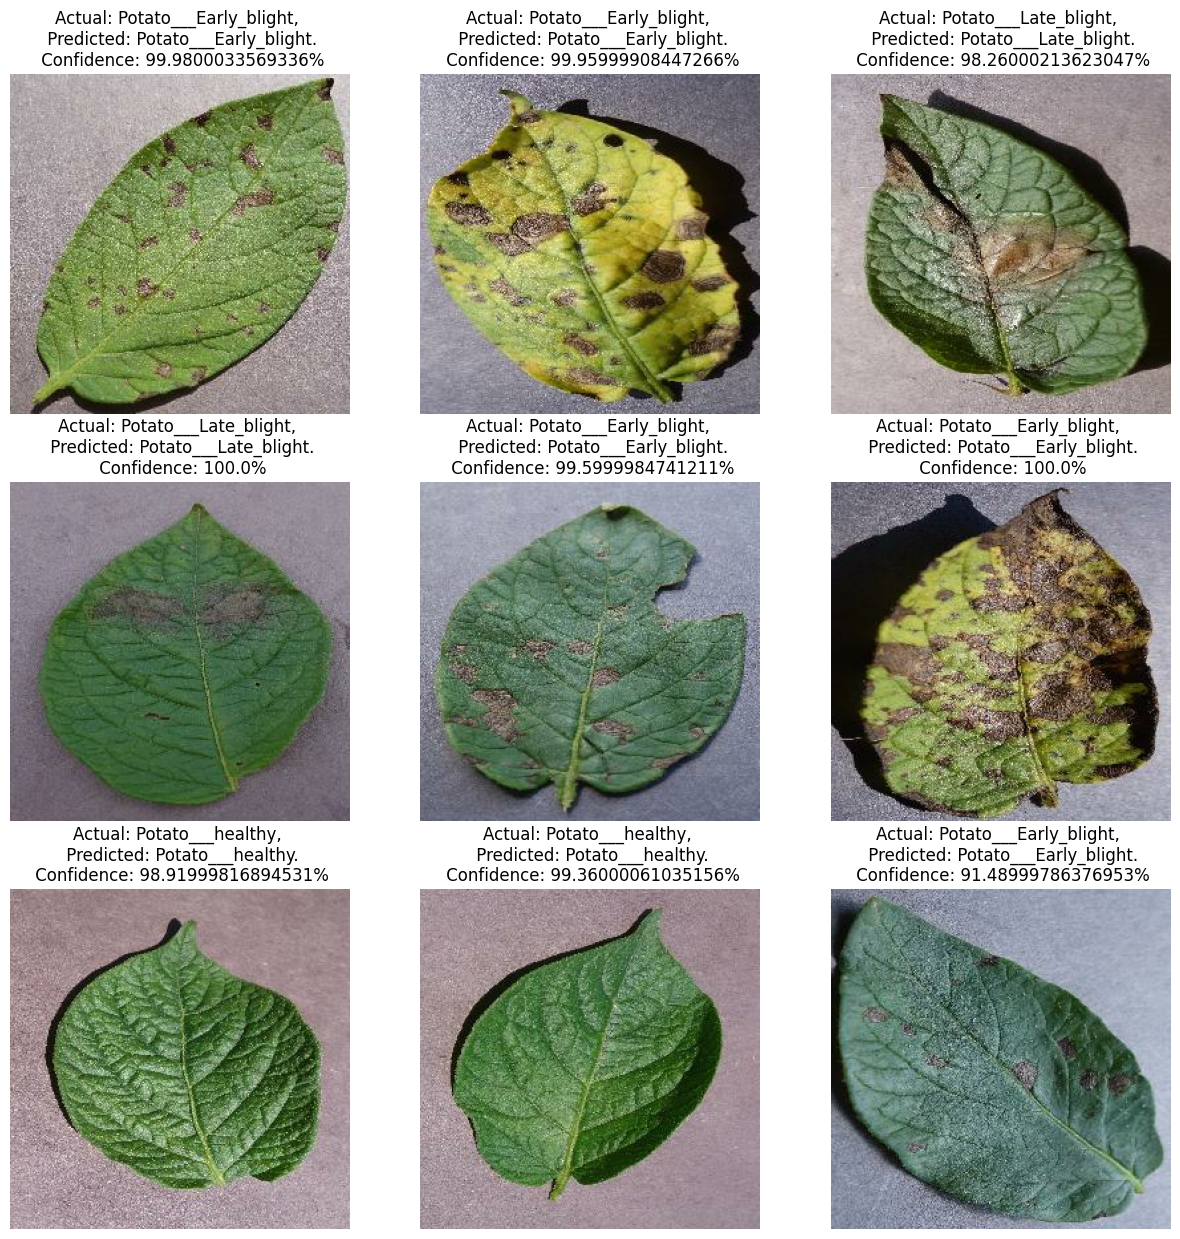

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names [labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")


In [76]:
import os

# Get the list of existing model versions in the ../models folder
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

# Filter only files that end with .keras and extract numeric version
existing_versions = [
    int(f.split(".")[0]) for f in os.listdir(model_dir)
    if f.endswith(".keras") and f.split(".")[0].isdigit()
]

# Determine next version number
model_version = max(existing_versions + [0]) + 1

# Define full path with .keras extension
save_path = os.path.join(model_dir, f"{model_version}.keras")

# Save the model
model.save(save_path)

print(f"Model saved to: {save_path}")


Model saved to: ../models/3.keras


In [33]:
import os

# Create model directory if it doesn't exist
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

# Get existing versions
existing_versions = [
    int(f.split(".")[0]) for f in os.listdir(model_dir)
    if f.endswith(".h5") and f.split(".")[0].isdigit()
]

# Set next version
model_version = max(existing_versions + [0]) + 1

# Save path
save_path = os.path.join(model_dir, f"{model_version}.h5")

# Save the model in HDF5 format
model.save(save_path)

print(f"Model saved to: {save_path}")


Model saved to: ../models/1.h5


In [1]:
pip install plantuml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plantuml]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /home/valmiki-uday-kiran/tensorflow_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import urllib.request

url = "https://github.com/plantuml/plantuml/releases/download/v1.2025.0/plantuml-1.2025.0.jar"
urllib.request.urlretrieve(url, "plantuml.jar")
print("Downloaded plantuml.jar")


Downloaded plantuml.jar


In [3]:
import os
print("plantuml.jar exists?", os.path.exists("plantuml.jar"))


plantuml.jar exists? True


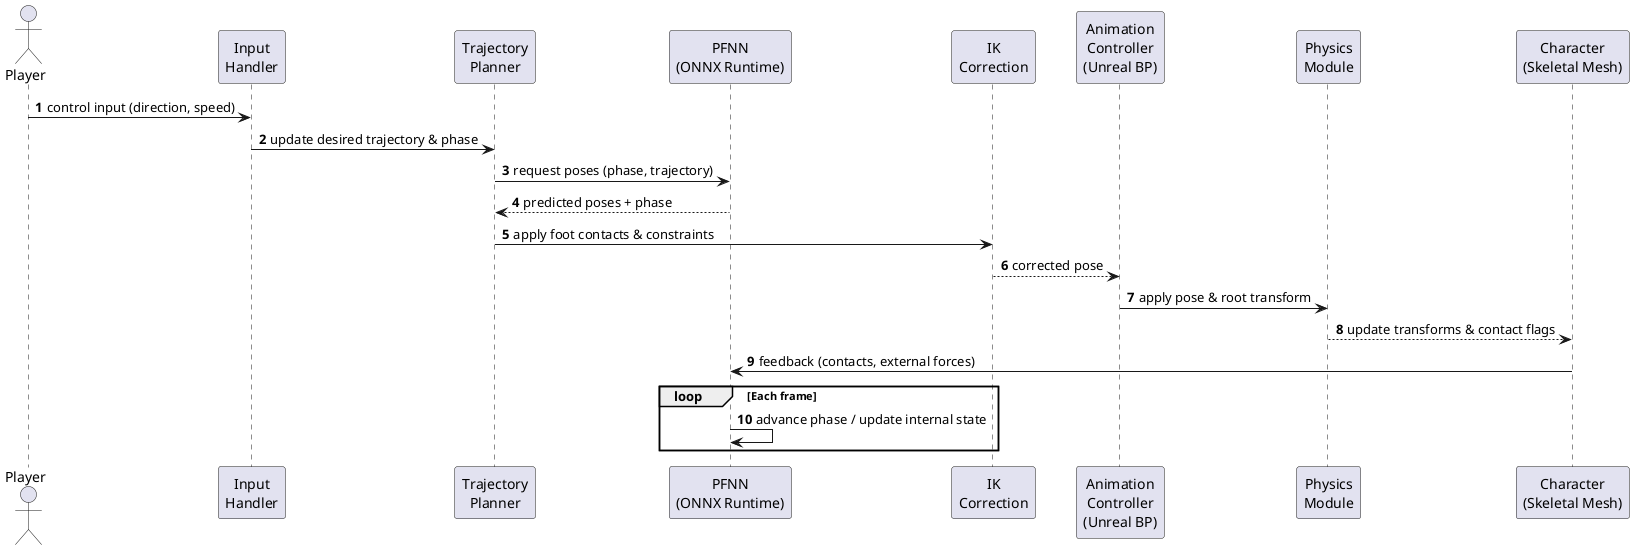

In [4]:
import subprocess
from IPython.display import Image, display

plantuml_code = r"""
@startuml
autonumber
actor Player
participant "Input\nHandler" as InputHandler
participant "Trajectory\nPlanner" as TrajectoryPlanner
participant "PFNN\n(ONNX Runtime)" as PFNN
participant "IK\nCorrection" as IK
participant "Animation\nController\n(Unreal BP)" as Anim
participant "Physics\nModule" as Physics
participant "Character\n(Skeletal Mesh)" as Character

Player -> InputHandler : control input (direction, speed)
InputHandler -> TrajectoryPlanner : update desired trajectory & phase
TrajectoryPlanner -> PFNN : request poses (phase, trajectory)
PFNN --> TrajectoryPlanner : predicted poses + phase
TrajectoryPlanner -> IK : apply foot contacts & constraints
IK --> Anim : corrected pose
Anim -> Physics : apply pose & root transform
Physics --> Character : update transforms & contact flags
Character -> PFNN : feedback (contacts, external forces)
loop Each frame
  PFNN -> PFNN : advance phase / update internal state
end
@enduml
"""

# Save .puml
with open("diagram.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML (requires Java installed)
subprocess.run(["java", "-jar", "plantuml.jar", "diagram.puml"], check=True)

# Display PNG
display(Image("diagram.png"))


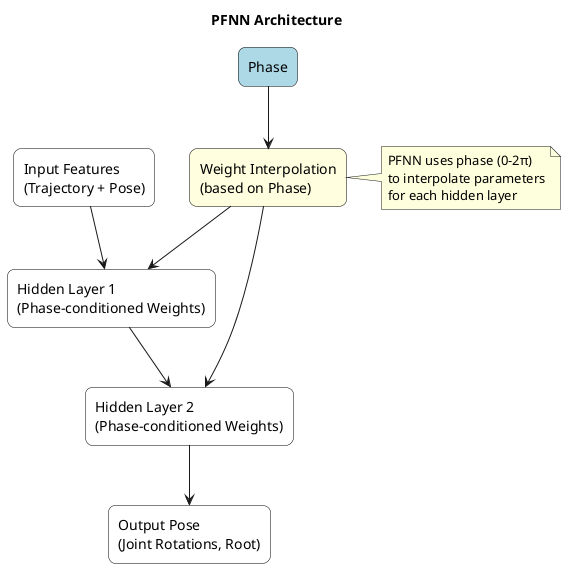

In [8]:
import subprocess
from IPython.display import Image, display

# Corrected PFNN Architecture diagram in PlantUML
plantuml_code = r"""
@startuml
title PFNN Architecture

skinparam rectangle {
  BackgroundColor White
  BorderColor Black
  RoundCorner 15
}

rectangle "Input Features\n(Trajectory + Pose)" as Input
rectangle "Hidden Layer 1\n(Phase-conditioned Weights)" as HL1
rectangle "Hidden Layer 2\n(Phase-conditioned Weights)" as HL2
rectangle "Output Pose\n(Joint Rotations, Root)" as Output

rectangle "Phase" as Phase #lightblue
rectangle "Weight Interpolation\n(based on Phase)" as WInterp #lightyellow

' Connections
Input --> HL1
HL1 --> HL2
HL2 --> Output

Phase --> WInterp
WInterp --> HL1
WInterp --> HL2

note right of WInterp
  PFNN uses phase (0–2π)
  to interpolate parameters
  for each hidden layer
end note

@enduml
"""

# Save PlantUML code
with open("pfnn_architecture.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML to generate PNG
subprocess.run(["java", "-jar", "plantuml.jar", "pfnn_architecture.puml"], check=True)

# Display the generated diagram
display(Image("pfnn_architecture.png"))


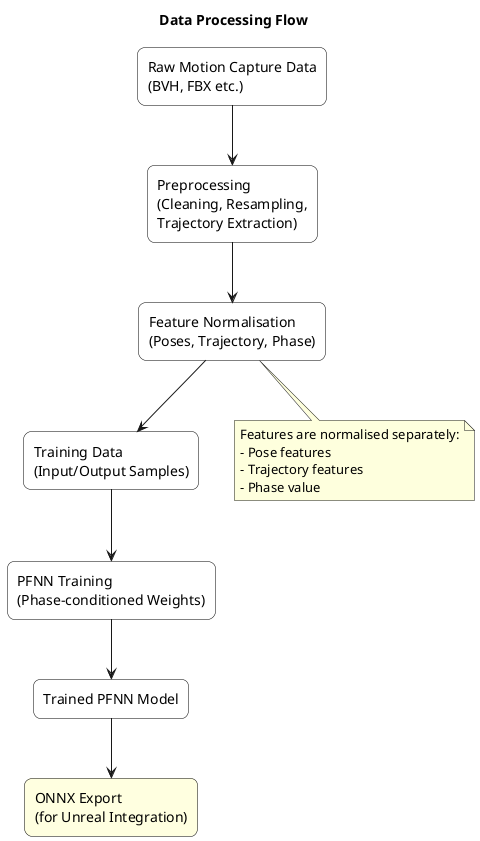

In [7]:
import subprocess
from IPython.display import Image, display

# Corrected Data Processing Flow (Slide 8.2)
plantuml_code = r"""
@startuml
title Data Processing Flow

skinparam rectangle {
  BackgroundColor White
  BorderColor Black
  RoundCorner 15
}

rectangle "Raw Motion Capture Data\n(BVH, FBX etc.)" as Raw
rectangle "Preprocessing\n(Cleaning, Resampling,\nTrajectory Extraction)" as Preproc
rectangle "Feature Normalisation\n(Poses, Trajectory, Phase)" as Norm
rectangle "Training Data\n(Input/Output Samples)" as TrainData
rectangle "PFNN Training\n(Phase-conditioned Weights)" as Train
rectangle "Trained PFNN Model" as Model
rectangle "ONNX Export\n(for Unreal Integration)" as ONNX #lightyellow

Raw --> Preproc
Preproc --> Norm
Norm --> TrainData
TrainData --> Train
Train --> Model
Model --> ONNX

note bottom of Norm
  Features are normalised separately:
  - Pose features
  - Trajectory features
  - Phase value
end note

@enduml
"""

# Save PlantUML code
with open("data_processing.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML to generate PNG
subprocess.run(["java", "-jar", "plantuml.jar", "data_processing.puml"], check=True)

# Display the generated diagram
display(Image("data_processing.png"))


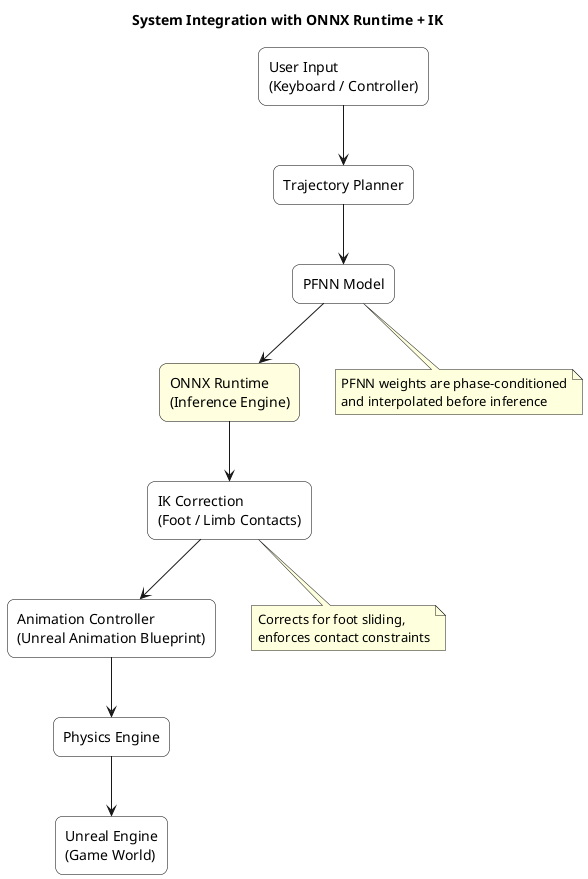

In [10]:
import subprocess
from IPython.display import Image, display

# Corrected System Integration Diagram (Slide 9.1/9.2)
plantuml_code = r"""
@startuml
title System Integration with ONNX Runtime + IK 

skinparam rectangle {
  BackgroundColor White
  BorderColor Black
  RoundCorner 15
}

rectangle "User Input\n(Keyboard / Controller)" as Input
rectangle "Trajectory Planner" as Traj
rectangle "PFNN Model" as PFNN
rectangle "ONNX Runtime\n(Inference Engine)" as ONNX #lightyellow
rectangle "IK Correction\n(Foot / Limb Contacts)" as IK
rectangle "Animation Controller\n(Unreal Animation Blueprint)" as Anim
rectangle "Physics Engine" as Physics
rectangle "Unreal Engine\n(Game World)" as Unreal

Input --> Traj
Traj --> PFNN
PFNN --> ONNX
ONNX --> IK
IK --> Anim
Anim --> Physics
Physics --> Unreal

note bottom of PFNN
  PFNN weights are phase-conditioned
  and interpolated before inference
end note

note bottom of IK
  Corrects for foot sliding,
  enforces contact constraints
end note

@enduml
"""

# Save PlantUML code
with open("system_integration.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML to generate PNG
subprocess.run(["java", "-jar", "plantuml.jar", "system_integration.puml"], check=True)

# Display the generated diagram
display(Image("system_integration.png"))


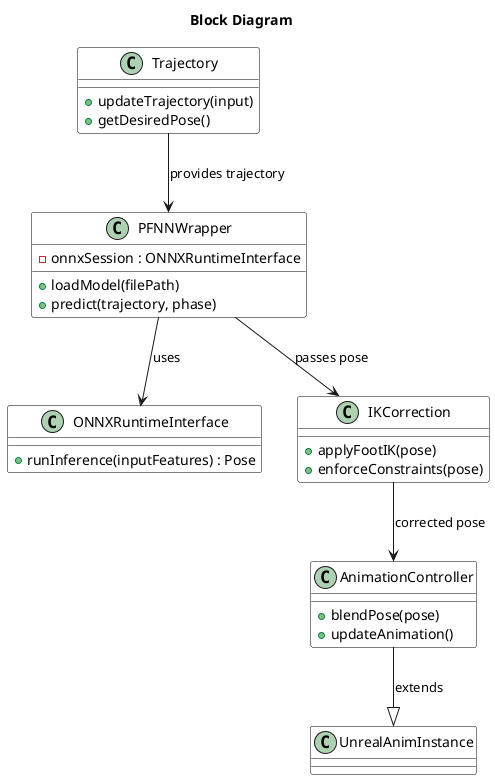

In [12]:
import subprocess
from IPython.display import Image, display

# Corrected Class Diagram (Slide 10.2)
plantuml_code = r"""
@startuml
title Block Diagram

skinparam class {
  BackgroundColor White
  BorderColor Black
}

class Trajectory {
  + updateTrajectory(input)
  + getDesiredPose()
}

class PFNNWrapper {
  - onnxSession : ONNXRuntimeInterface
  + loadModel(filePath)
  + predict(trajectory, phase)
}

class ONNXRuntimeInterface {
  + runInference(inputFeatures) : Pose
}

class IKCorrection {
  + applyFootIK(pose)
  + enforceConstraints(pose)
}

class AnimationController {
  + blendPose(pose)
  + updateAnimation()
}

class UnrealAnimInstance {
}

' Relationships
Trajectory --> PFNNWrapper : provides trajectory
PFNNWrapper --> ONNXRuntimeInterface : uses
PFNNWrapper --> IKCorrection : passes pose
IKCorrection --> AnimationController : corrected pose
AnimationController --|> UnrealAnimInstance : extends

@enduml
"""

# Save PlantUML code
with open("class_diagram.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML to generate PNG
subprocess.run(["java", "-jar", "plantuml.jar", "class_diagram.puml"], check=True)

# Display the generated diagram
display(Image("class_diagram.png"))


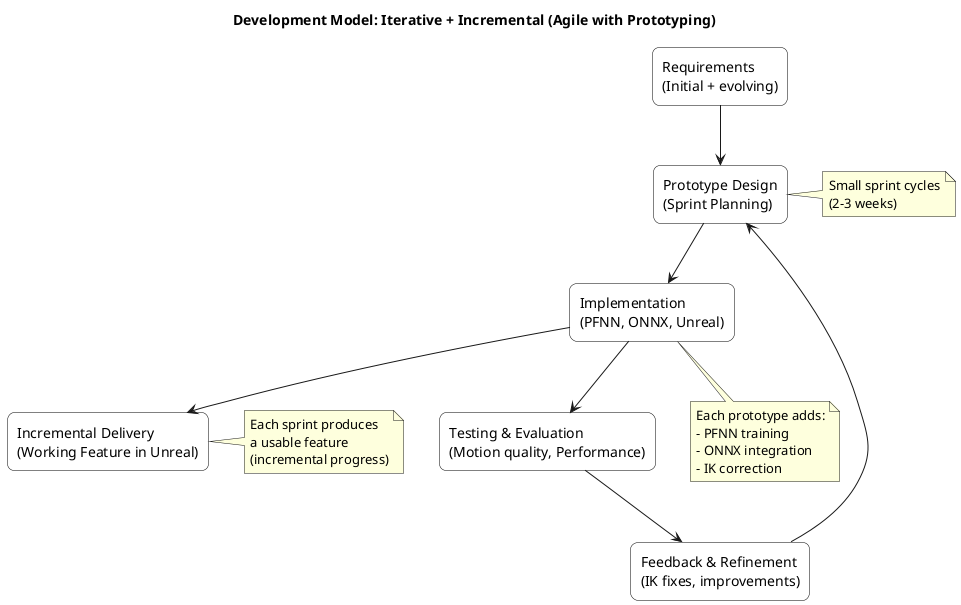

In [13]:
import subprocess
from IPython.display import Image, display

# Development Model Diagram (Agile + Prototyping)
plantuml_code = r"""
@startuml
title Development Model: Iterative + Incremental (Agile with Prototyping)

skinparam rectangle {
  BackgroundColor White
  BorderColor Black
  RoundCorner 15
}

rectangle "Requirements\n(Initial + evolving)" as Req
rectangle "Prototype Design\n(Sprint Planning)" as Design
rectangle "Implementation\n(PFNN, ONNX, Unreal)" as Impl
rectangle "Testing & Evaluation\n(Motion quality, Performance)" as Test
rectangle "Feedback & Refinement\n(IK fixes, improvements)" as Feedback
rectangle "Incremental Delivery\n(Working Feature in Unreal)" as Delivery

Req --> Design
Design --> Impl
Impl --> Test
Test --> Feedback
Feedback --> Design
Impl --> Delivery

note right of Design
  Small sprint cycles
  (2–3 weeks)
end note

note bottom of Impl
  Each prototype adds:
  - PFNN training
  - ONNX integration
  - IK correction
end note

note right of Delivery
  Each sprint produces
  a usable feature
  (incremental progress)
end note

@enduml
"""

# Save PlantUML code
with open("development_model.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML to generate PNG
subprocess.run(["java", "-jar", "plantuml.jar", "development_model.puml"], check=True)

# Display the generated diagram
display(Image("development_model.png"))


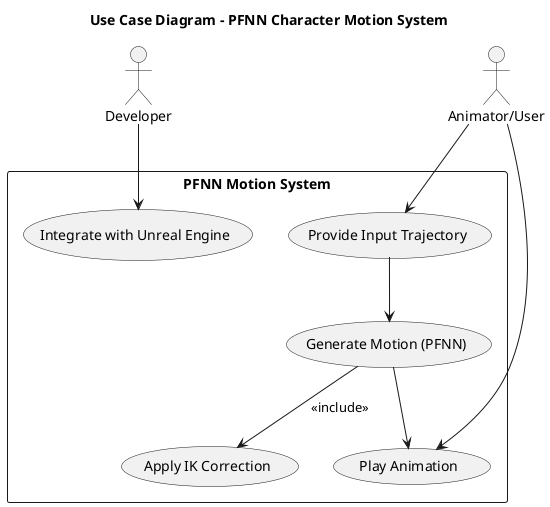

In [14]:
import subprocess
from IPython.display import Image, display

# Corrected Use Case Diagram
plantuml_code = r"""
@startuml
title Use Case Diagram - PFNN Character Motion System

actor "Developer" as Dev
actor "Animator/User" as User

rectangle "PFNN Motion System" {
    usecase "Provide Input Trajectory" as UC1
    usecase "Generate Motion (PFNN)" as UC2
    usecase "Apply IK Correction" as UC3
    usecase "Integrate with Unreal Engine" as UC4
    usecase "Play Animation" as UC5
}

User --> UC1
User --> UC5
UC2 --> UC3 : <<include>>
Dev --> UC4
UC1 --> UC2
UC2 --> UC5

@enduml
"""

# Save .puml
with open("usecase.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML
subprocess.run(["java", "-jar", "plantuml.jar", "usecase.puml"], check=True)

# Display result
display(Image("usecase.png"))


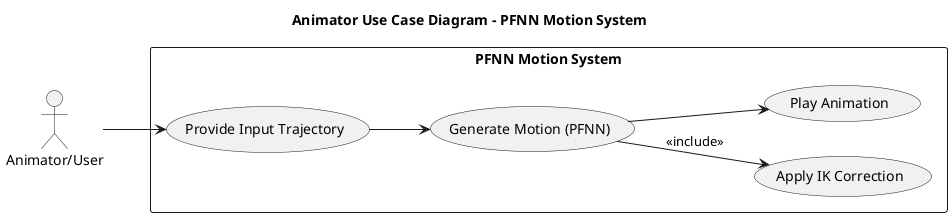

In [16]:
import subprocess
from IPython.display import Image, display

# Animator-focused Use Case Diagram
plantuml_code = r"""
@startuml
title Animator Use Case Diagram - PFNN Motion System

left to right direction

actor "Animator/User" as User

rectangle "PFNN Motion System" {
    usecase "Provide Input Trajectory" as UC1
    usecase "Generate Motion (PFNN)" as UC2
    usecase "Apply IK Correction" as UC3
    usecase "Play Animation" as UC4
}

User --> UC1
UC1 --> UC2
UC2 --> UC3 : <<include>>
UC2 --> UC4

@enduml
"""

# Save .puml
with open("animator_usecase.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML to generate PNG
subprocess.run(["java", "-jar", "plantuml.jar", "animator_usecase.puml"], check=True)

# Display result
display(Image("animator_usecase.png"))


In [1]:
# Jupyter cell: render a PFNN Level-0 context diagram via PlantUML server
# Paste into a notebook cell and run. (Requires internet to fetch the image from plantuml.com)

plantuml_text = r"""
@startuml
' --- simple styling for a clean context diagram
skinparam dpi 150
skinparam rectangle {
  BackgroundColor #f8f9fb
  BorderColor #2b2b2b
}
left to right direction

actor "Developer / Animator\n(controls)" as DEV
actor "Motion-capture Dataset\n(CMU / SFU / HDM05)" as MOCAP
database "Model Repository\n(ONNX / storage)" as REPO
actor "Terrain / Environment\n(heightmap, sensors)" as TERR
actor "Unreal Engine\n(runtime)" as UE

rectangle "PFNN Animation System\n(Phase-Functioned NN + runtime adaptor)" as PFNN

' external -> system flows
MOCAP --> PFNN : "mocap training data"
DEV --> PFNN   : "control commands\n(direction, speed, behavior)"
TERR --> PFNN  : "terrain info\n(heightmap, normals)"
UE --> PFNN    : "runtime feedback\n(collision / contacts)"

' system -> external flows
PFNN --> UE    : "animation poses / pose stream"
PFNN --> REPO  : "trained model (ONNX) / logs"
PFNN --> DEV   : "status / diagnostics"

@enduml
"""

# PlantUML encode (zlib deflate + PlantUML base64 variant)
def _encode_6bit(b):
    if b < 10:
        return chr(48 + b)
    b -= 10
    if b < 26:
        return chr(65 + b)
    b -= 26
    if b < 26:
        return chr(97 + b)
    b -= 26
    if b == 0:
        return '-'
    if b == 1:
        return '_'
    return '?'

def _append3bytes(b1, b2, b3):
    c1 = b1 >> 2
    c2 = ((b1 & 0x3) << 4) | (b2 >> 4)
    c3 = ((b2 & 0xF) << 2) | (b3 >> 6)
    c4 = b3 & 0x3F
    return _encode_6bit(c1) + _encode_6bit(c2) + _encode_6bit(c3) + _encode_6bit(c4)

def plantuml_encode(plantuml_text: str) -> str:
    import zlib
    data = zlib.compress(plantuml_text.encode('utf-8'))
    # remove zlib header and checksum (PlantUML expects raw deflate block)
    data = data[2:-4]
    res = []
    i = 0
    n = len(data)
    while i < n:
        b1 = data[i] if i < n else 0; i += 1
        b2 = data[i] if i < n else 0; i += 1
        b3 = data[i] if i < n else 0; i += 1
        res.append(_append3bytes(b1, b2, b3))
    return ''.join(res)

encoded = plantuml_encode(plantuml_text)
plantuml_png_url = "https://www.plantuml.com/plantuml/png/" + encoded

# display inline in Jupyter
from IPython.display import Image, display
display(Image(url=plantuml_png_url))
print("If the image doesn't load, copy this URL into a browser:\n", plantuml_png_url)


If the image doesn't load, copy this URL into a browser:
 https://www.plantuml.com/plantuml/png/LLFBRjim4BppAnRgeGqQ8Mc106qFGL9RHYz-m8c377gXfPLCX5mA9ENMAFhltPNaHs50jgcPsTtPeNg8IOVKEQlUGvxd48rhBK9C1skeWTe7q51Qr0IbfuI_4rH6Dq4x5TyCjPf_GTKQ-7HtUt4Ii4oQ6bRwem2-w_Aj2RwZQk8jAxwhlzHVwwsyyQ72C9v-tif7_LKMwmJ9Gp3DJkg9cl6ab2uJ0xCfxj7w5WFSm2CPf_dq9tsG1eEtyIe37M5Ql1pnSo_qlDHjwWB2L2STCJ5ZCj-mnDDCdZ-cyzkxWJfVJXvNgcBObe72hz326biV3GiUcBbSB5wP5FclRd2WhOlLybZo6KFGXXXIqDu4Jmv9AkvGPdAwlOQ857qOktqkrkiZTqC1jMLYOmYP4pfAner5DeLIPtUprMon63tW4U7f41Cwvgnst7a-wwXt3YjWs4SObK1NR8KFWw98A5u_xnO3SU7y7cAl0xNrlwBgxU1qtFTG-0QPy-mb99bGKY9EPOeDFuD0OED2E3dEQQeYztLQ9i_V8bRNiCMTtXjfHea95nAia4OR3TN-V_V81wTbrsfJN9OLrd7CcWjiENjzDgmrKIowwOFCLWkNnnv7POMJ0SFOlQ0eSu51LvzyvYHWP2dvvX3mlbns9aWGXlQbUJRVzG7gGtF5BEkRU04NuteutyNKYQnSCV8ncP9nwW6faXlw3m00


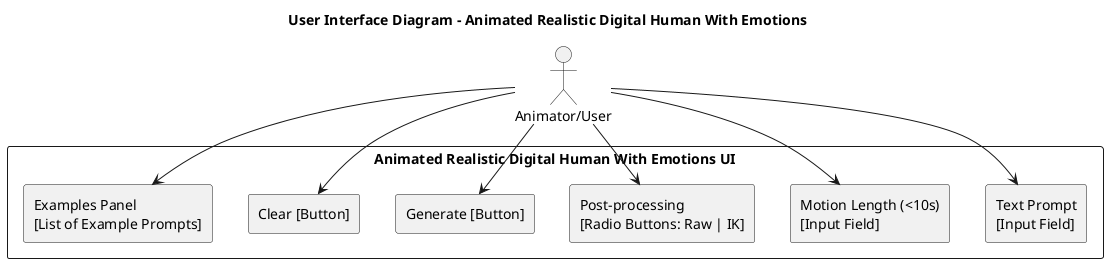

In [1]:
import subprocess
from IPython.display import Image, display

# User Interface Diagram based on the provided screenshot
plantuml_code = r"""
@startuml
title User Interface Diagram - Animated Realistic Digital Human With Emotions

actor "Animator/User" as User

rectangle "Animated Realistic Digital Human With Emotions UI" {
  
  rectangle "Text Prompt\n[Input Field]" as Prompt
  rectangle "Motion Length (<10s)\n[Input Field]" as MotionLen
  rectangle "Post-processing\n[Radio Buttons: Raw | IK]" as PostProc
  rectangle "Generate [Button]" as GenBtn
  rectangle "Clear [Button]" as ClearBtn
  rectangle "Examples Panel\n[List of Example Prompts]" as Examples
  
}

User --> Prompt
User --> MotionLen
User --> PostProc
User --> GenBtn
User --> ClearBtn
User --> Examples

@enduml
"""

# Save PlantUML code
with open("ui_diagram.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML
subprocess.run(["java", "-jar", "plantuml.jar", "ui_diagram.puml"], check=True)

# Display the diagram
display(Image("ui_diagram.png"))


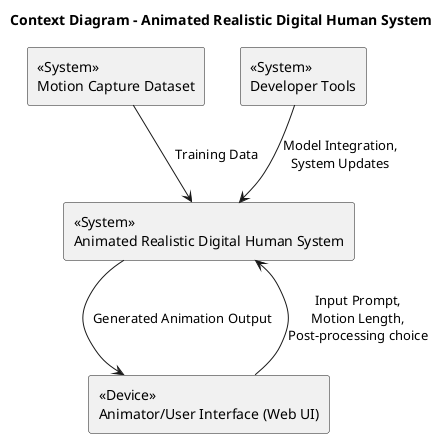

In [4]:
import subprocess
from IPython.display import Image, display

# Styled Context Diagram (like your Smart Shelter System example)
plantuml_code = r"""
@startuml
title Context Diagram - Animated Realistic Digital Human System

rectangle "<<System>>\nMotion Capture Dataset" as Dataset
rectangle "<<System>>\nDeveloper Tools" as Dev
rectangle "<<System>>\nAnimated Realistic Digital Human System" as System
rectangle "<<Device>>\nAnimator/User Interface (Web UI)" as UserUI

Dataset --> System : Training Data
Dev --> System : Model Integration,\nSystem Updates
UserUI --> System : Input Prompt,\nMotion Length,\nPost-processing choice
System --> UserUI : Generated Animation Output

@enduml
"""

# Save PlantUML code
with open("context_diagram_styled.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML
subprocess.run(["java", "-jar", "plantuml.jar", "context_diagram_styled.puml"], check=True)

# Display the generated diagram
display(Image("context_diagram_styled.png"))


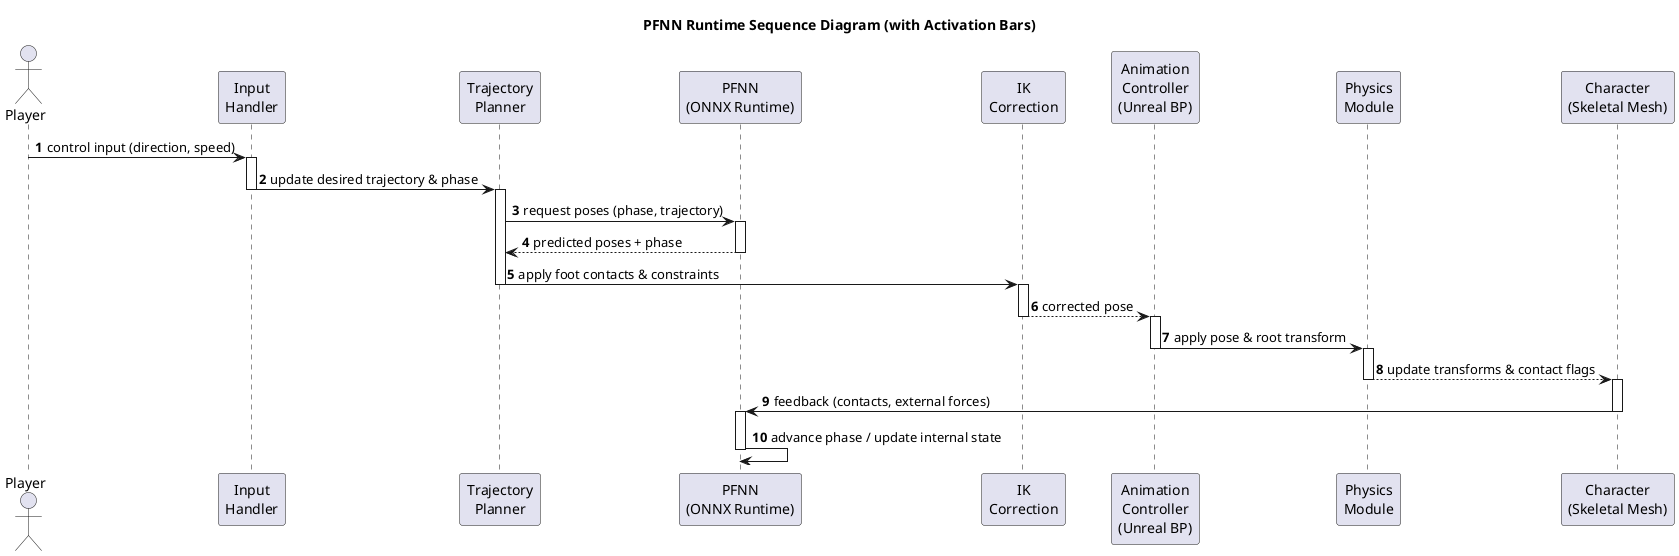

In [1]:
import subprocess
from IPython.display import Image, display

# Sequence Diagram with activation bars
plantuml_code = r"""
@startuml
title PFNN Runtime Sequence Diagram (with Activation Bars)

autonumber
actor Player
participant "Input\nHandler" as InputHandler
participant "Trajectory\nPlanner" as TrajectoryPlanner
participant "PFNN\n(ONNX Runtime)" as PFNN
participant "IK\nCorrection" as IK
participant "Animation\nController\n(Unreal BP)" as Anim
participant "Physics\nModule" as Physics
participant "Character\n(Skeletal Mesh)" as Character

Player -> InputHandler : control input (direction, speed)
activate InputHandler
InputHandler -> TrajectoryPlanner : update desired trajectory & phase
deactivate InputHandler

activate TrajectoryPlanner
TrajectoryPlanner -> PFNN : request poses (phase, trajectory)
activate PFNN
PFNN --> TrajectoryPlanner : predicted poses + phase
deactivate PFNN

TrajectoryPlanner -> IK : apply foot contacts & constraints
deactivate TrajectoryPlanner

activate IK
IK --> Anim : corrected pose
deactivate IK

activate Anim
Anim -> Physics : apply pose & root transform
deactivate Anim

activate Physics
Physics --> Character : update transforms & contact flags
deactivate Physics

activate Character
Character -> PFNN : feedback (contacts, external forces)
deactivate Character

activate PFNN
PFNN -> PFNN : advance phase / update internal state
deactivate PFNN

@enduml
"""

# Save .puml
with open("sequence_with_activation.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML to generate PNG
subprocess.run(["java", "-jar", "plantuml.jar", "sequence_with_activation.puml"], check=True)

# Display the diagram
display(Image("sequence_with_activation.png"))


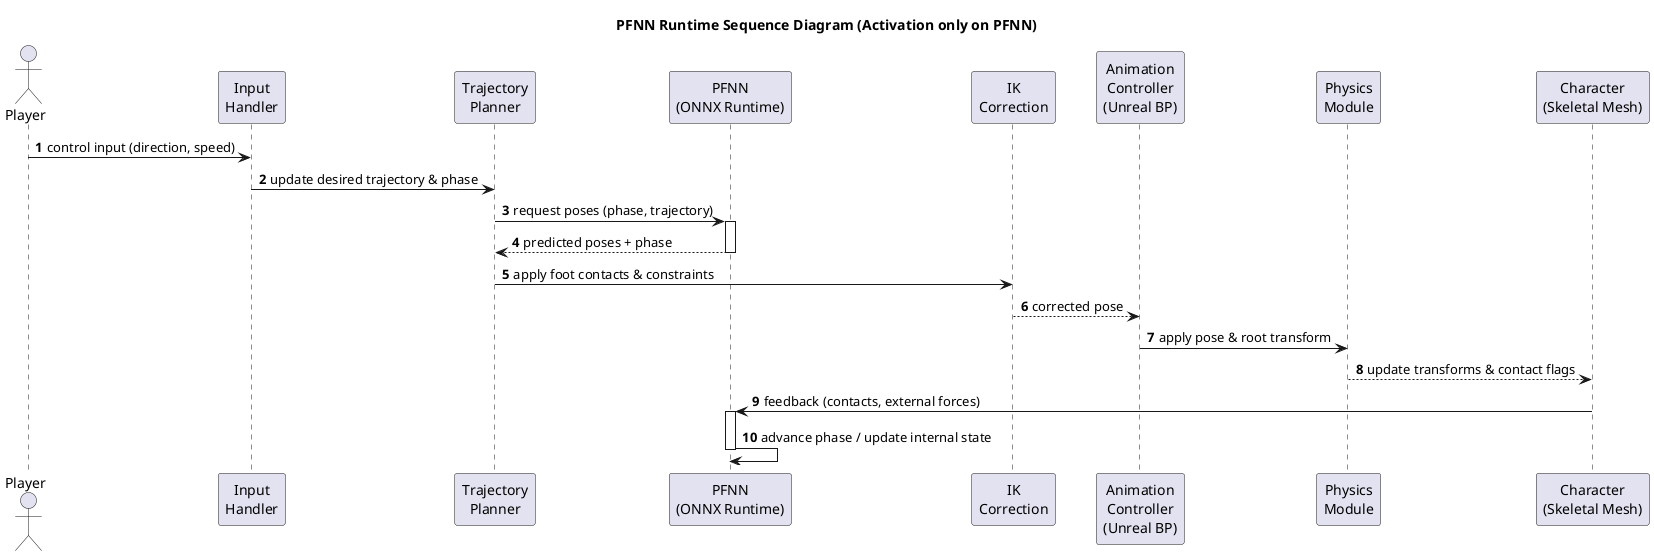

In [2]:
import subprocess
from IPython.display import Image, display

# Sequence Diagram - Activation only on PFNN
plantuml_code = r"""
@startuml
title PFNN Runtime Sequence Diagram (Activation only on PFNN)

autonumber
actor Player
participant "Input\nHandler" as InputHandler
participant "Trajectory\nPlanner" as TrajectoryPlanner
participant "PFNN\n(ONNX Runtime)" as PFNN
participant "IK\nCorrection" as IK
participant "Animation\nController\n(Unreal BP)" as Anim
participant "Physics\nModule" as Physics
participant "Character\n(Skeletal Mesh)" as Character

Player -> InputHandler : control input (direction, speed)
InputHandler -> TrajectoryPlanner : update desired trajectory & phase
TrajectoryPlanner -> PFNN : request poses (phase, trajectory)

activate PFNN
PFNN --> TrajectoryPlanner : predicted poses + phase
deactivate PFNN

TrajectoryPlanner -> IK : apply foot contacts & constraints
IK --> Anim : corrected pose
Anim -> Physics : apply pose & root transform
Physics --> Character : update transforms & contact flags
Character -> PFNN : feedback (contacts, external forces)

activate PFNN
PFNN -> PFNN : advance phase / update internal state
deactivate PFNN

@enduml
"""

# Save .puml
with open("sequence_pfnn_activation.puml", "w") as f:
    f.write(plantuml_code)

# Run PlantUML
subprocess.run(["java", "-jar", "plantuml.jar", "sequence_pfnn_activation.puml"], check=True)

# Display result
display(Image("sequence_pfnn_activation.png"))


In [1]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.2 MB/s eta 0:00:00 MB/s eta 0:00:01:010m

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch

# Setup document with margins
doc = SimpleDocTemplate(
    "Drone_Hardware_Components.pdf",
    pagesize=A4,
    rightMargin=50,
    leftMargin=50,
    topMargin=50,
    bottomMargin=50
)

styles = getSampleStyleSheet()
styles.add(ParagraphStyle(name="ComponentTitle", fontSize=16, leading=20, spaceAfter=10, alignment=1, textColor="darkblue"))
styles.add(ParagraphStyle(name="SpecText", fontSize=11, leading=15, spaceAfter=5))

story = []

# Components list (basic info, you can extend specs/features easily)
components = [
    {
        "no": 1,
        "name": "MicoAir NxtPX4 V2 Mini Flight Controller + 33A ESC",
        "link": "https://www.drkstore.in/micoair-nxtpx4-v2-mini-flight-controller-w-optional-33a-esc/?srsltid=AfmBOopzFvsQbXgvN4vmFsICRs5iLEKQFQwTYVeqyKcH16C5HWUan4DornE",
        "image": "comp1.jpg",
        "weight": "Approx 12g (controller only)",
        "specs": "32-bit ARM Cortex-M4 processor, 33A integrated ESC support, 8 PWM outputs",
        "features": "High-performance flight control, reliable power distribution"
    },
    {
        "no": 2,
        "name": "Arducam High Quality IR-CUT Camera (12.3MP, IMX477)",
        "link": "https://robu.in/product/arducam-high-quality-ir-cut-camera-for-jetson-nano-xavier-nx-12-3mp-1-2-3-inch-imx477-hq-camera-module-with-6mm-cs-lens/",
        "image": "comp2.jpg",
        "weight": "Approx 20g",
        "specs": "12.3MP IMX477 sensor, IR-CUT filter, 6mm CS Lens",
        "features": "High-resolution imaging, night/day clarity"
    },
    {
        "no": 3,
        "name": "Emax ECOII-2306-1900KV Brushless Motor",
        "link": "https://robu.in/product/emax-ecoii-2306-1900kv-brushless-motor/",
        "image": "comp3.jpg",
        "weight": "Approx 29g",
        "specs": "KV: 1900, Shaft: 5mm, Voltage: 2–6S LiPo",
        "features": "Efficient power, strong thrust, smooth bearings"
    },
    {
        "no": 4,
        "name": "Pro-Range Propellers 5045 Carbon Nylon (2CW+2CCW)",
        "link": "https://robu.in/product/orange-hd-propellers-50455x4-5-carbon-nylon-2cw2ccw-2pairs-black/",
        "image": "comp4.jpg",
        "weight": "Approx 13g per pair",
        "specs": "Size: 5x4.5 inch, Material: Carbon Nylon",
        "features": "Durable, balanced performance, reduced vibration"
    },
    {
        "no": 5,
        "name": "Bonka 14.8V 10000mAh 25C 4S LiPo Battery",
        "link": "https://robu.in/product/bonka-11-1v-10000mah-25c-3s-lithium-polymer-battery-pack/",
        "image": "comp5.jpg",
        "weight": "Approx 800g",
        "specs": "Voltage: 14.8V, Capacity: 10000mAh, Discharge Rate: 25C",
        "features": "High capacity, long endurance, stable discharge"
    },
    {
        "no": 6,
        "name": "Waveshare Dedicated Cooling Fan for Jetson Nano",
        "link": "https://robu.in/product/waveshare-dedicated-cooling-fan-for-jetson-nano-5v-with-3pin-reverse-proof/",
        "image": "comp6.jpg",
        "weight": "Approx 10g",
        "specs": "5V, 3-pin reverse-proof connector, low noise",
        "features": "Efficient cooling, easy installation"
    },
    {
        "no": 7,
        "name": "Nvidia Jetson Nano",
        "link": "https://developer.nvidia.com/embedded/jetson-nano-developer-kit",
        "image": "comp7.jpg",
        "weight": "Approx 140g",
        "specs": "Quad-core ARM Cortex-A57, 128-core Maxwell GPU, 4GB RAM",
        "features": "AI/ML support, GPU accelerated computing"
    },
    {
        "no": 8,
        "name": "NEO-M8N GPS with Compass for Pixhawk/APM",
        "link": "https://robu.in/product/ublox-neo-m8n-gps-for-apm-and-pixhawk-flight-controller/#tab-specification",
        "image": "comp8.jpg",
        "weight": "Approx 28g",
        "specs": "u-blox M8N GNSS, integrated compass, UART/I2C",
        "features": "Accurate positioning, strong satellite lock"
    },
    {
        "no": 9,
        "name": "Espressif ESP32-C6-MINI-1U",
        "link": "https://www.espressif.com/en/products/socs/esp32-c6",
        "image": "comp9.jpg",
        "weight": "Approx 3g",
        "specs": "Wi-Fi 6, Bluetooth 5.3, RISC-V CPU",
        "features": "Low-power IoT, secure connectivity"
    }
]

# Add each component
for comp in components:
    story.append(Paragraph(f"{comp['no']}. {comp['name']}", styles["ComponentTitle"]))
    
    # Specs & features
    details = f"""
    <b>Weight:</b> {comp['weight']}<br/>
    <b>Specifications:</b> {comp['specs']}<br/>
    <b>Features:</b> {comp['features']}<br/>
    <b>Link:</b> <a href="{comp['link']}">Click here</a>
    """
    story.append(Paragraph(details, styles["SpecText"]))
    story.append(Spacer(1, 10))
    
    # Image
    try:
        img = Image(comp["image"], width=4*inch, height=3*inch)
        story.append(img)
    except:
        story.append(Paragraph("Image not found", styles["SpecText"]))
    
    story.append(Spacer(1, 30))
    story.append(PageBreak())

# Build PDF
doc.build(story)
print("✅ PDF generated: Drone_Hardware_Components.pdf")


✅ PDF generated: Drone_Hardware_Components.pdf


In [6]:
import os
print(os.path.expanduser("~"))



/home/valmiki-uday-kiran


In [9]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch

# Save PDF in ../models/ folder (relative to training/)
doc = SimpleDocTemplate(
    "../models/Drone_Hardware_Components.pdf",
    pagesize=A4,
    rightMargin=50,
    leftMargin=50,
    topMargin=50,
    bottomMargin=50
)

styles = getSampleStyleSheet()
styles.add(ParagraphStyle(name="ComponentTitle", fontSize=16, leading=20, spaceAfter=10, alignment=1, textColor="darkblue"))
styles.add(ParagraphStyle(name="SpecText", fontSize=11, leading=15, spaceAfter=5))

story = []

# ... keep the rest of your components code same ...

# Build PDF
doc.build(story)
print("✅ PDF saved in models folder: ../models/Drone_Hardware_Components.pdf")


✅ PDF saved in models folder: ../models/Drone_Hardware_Components.pdf


In [12]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.pagesizes import A4

# Save PDF in ../models/ folder (relative to training/)
doc = SimpleDocTemplate(
    "../models/Drone_Hardware_Components.pdf",
    pagesize=A4,
    rightMargin=50,
    leftMargin=50,
    topMargin=50,
    bottomMargin=50
)

styles = getSampleStyleSheet()
styles.add(ParagraphStyle(name="ComponentTitle", fontSize=14, leading=18, spaceAfter=6, textColor="darkblue", alignment=0))
styles.add(ParagraphStyle(name="SpecText", fontSize=11, leading=14, spaceAfter=4))

story = []

# Components list without images
components = [
    {
        "no": 1,
        "name": "MicoAir NxtPX4 V2 Mini Flight Controller + 33A ESC",
        "link": "https://www.drkstore.in/micoair-nxtpx4-v2-mini-flight-controller-w-optional-33a-esc/?srsltid=AfmBOopzFvsQbXgvN4vmFsICRs5iLEKQFQwTYVeqyKcH16C5HWUan4DornE",
        "weight": "Approx 12g (controller only)",
        "specs": "32-bit ARM Cortex-M4 processor, 33A integrated ESC support, 8 PWM outputs",
        "features": "High-performance flight control, reliable power distribution"
    },
    {
        "no": 2,
        "name": "Arducam High Quality IR-CUT Camera (12.3MP, IMX477)",
        "link": "https://robu.in/product/arducam-high-quality-ir-cut-camera-for-jetson-nano-xavier-nx-12-3mp-1-2-3-inch-imx477-hq-camera-module-with-6mm-cs-lens/",
        "weight": "Approx 20g",
        "specs": "12.3MP IMX477 sensor, IR-CUT filter, 6mm CS Lens",
        "features": "High-resolution imaging, night/day clarity"
    },
    {
        "no": 3,
        "name": "Emax ECOII-2306-1900KV Brushless Motor",
        "link": "https://robu.in/product/emax-ecoii-2306-1900kv-brushless-motor/",
        "weight": "Approx 29g",
        "specs": "KV: 1900, Shaft: 5mm, Voltage: 2–6S LiPo",
        "features": "Efficient power, strong thrust, smooth bearings"
    },
    {
        "no": 4,
        "name": "Pro-Range Propellers 5045 Carbon Nylon (2CW+2CCW)",
        "link": "https://robu.in/product/orange-hd-propellers-50455x4-5-carbon-nylon-2cw2ccw-2pairs-black/",
        "weight": "Approx 13g per pair",
        "specs": "Size: 5x4.5 inch, Material: Carbon Nylon",
        "features": "Durable, balanced performance, reduced vibration"
    },
    {
        "no": 5,
        "name": "Bonka 14.8V 10000mAh 25C 4S LiPo Battery",
        "link": "https://robu.in/product/bonka-11-1v-10000mah-25c-3s-lithium-polymer-battery-pack/",
        "weight": "Approx 800g",
        "specs": "Voltage: 14.8V, Capacity: 10000mAh, Discharge Rate: 25C",
        "features": "High capacity, long endurance, stable discharge"
    },
    {
        "no": 6,
        "name": "Waveshare Dedicated Cooling Fan for Jetson Nano",
        "link": "https://robu.in/product/waveshare-dedicated-cooling-fan-for-jetson-nano-5v-with-3pin-reverse-proof/",
        "weight": "Approx 10g",
        "specs": "5V, 3-pin reverse-proof connector, low noise",
        "features": "Efficient cooling, easy installation"
    },
    {
        "no": 7,
        "name": "Nvidia Jetson Nano",
        "link": "https://developer.nvidia.com/embedded/jetson-nano-developer-kit",
        "weight": "Approx 140g",
        "specs": "Quad-core ARM Cortex-A57, 128-core Maxwell GPU, 4GB RAM",
        "features": "AI/ML support, GPU accelerated computing"
    },
    {
        "no": 8,
        "name": "NEO-M8N GPS with Compass for Pixhawk/APM",
        "link": "https://robu.in/product/ublox-neo-m8n-gps-for-apm-and-pixhawk-flight-controller/#tab-specification",
        "weight": "Approx 28g",
        "specs": "u-blox M8N GNSS, integrated compass, UART/I2C",
        "features": "Accurate positioning, strong satellite lock"
    },
    {
        "no": 9,
        "name": "Espressif ESP32-C6-MINI-1U",
        "link": "https://www.espressif.com/en/products/socs/esp32-c6",
        "weight": "Approx 3g",
        "specs": "Wi-Fi 6, Bluetooth 5.3, RISC-V CPU",
        "features": "Low-power IoT, secure connectivity"
    }
]

# Add each component to PDF
for comp in components:
    story.append(Paragraph(f"{comp['no']}. {comp['name']}", styles["ComponentTitle"]))

    details = f"""
    <b>Weight:</b> {comp['weight']}<br/>
    <b>Specifications:</b> {comp['specs']}<br/>
    <b>Features:</b> {comp['features']}<br/>
    <b>Link:</b> <a href="{comp['link']}">{comp['link']}</a>
    """
    story.append(Paragraph(details, styles["SpecText"]))
    story.append(Spacer(1, 15))

# Build PDF
doc.build(story)
print("✅ PDF saved in models folder: ../models/Drone_Hardware_Components.pdf")

✅ PDF saved in models folder: ../models/Drone_Hardware_Components.pdf


In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [11]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# Load dataset
iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 1)  # Iris setosa = True

# Train perceptron
per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

# Predict new flowers
X_new = [[3, 3], [3, 1]]
y_pred = per_clf.predict(X_new)

print("Predictions:", y_pred)


Predictions: [False False]


In [3]:
import sys
!{sys.executable} -m pip install pandas


  Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]━━━━━━━━━━━ 2/3 [pandas]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [9]:
import numpy as np
from sklearn.datasets import load_iris

# Load dataset
iris = load_iris()
X = iris.data[:, [2, 3]]  # petal length, petal width
y = (iris.target == 0).astype(int)  # 1 if Setosa, else 0

# Initialize weights
w = np.zeros(X.shape[1])  # two features → two weights
b = 0
learning_rate = 0.1
epochs = 10

# Training loop
for epoch in range(epochs):
    for xi, target in zip(X, y):
        # Prediction (step function)
        linear_output = np.dot(xi, w) + b
        y_pred = 1 if linear_output >= 0 else 0

        # Update rule
        error = target - y_pred
        w += learning_rate * error * xi
        b += learning_rate * error

print("Trained weights:", w)
print("Trained bias:", b)

# Prediction function
def predict(x):
    return 1 if np.dot(x, w) + b >= 0 else 0

# Test on new flowers
X_new = [[2, 0.5], [3, 1]]
for flower in X_new:
    print(flower, "->", "Setosa" if predict(flower) else "Not Setosa")


Trained weights: [-0.06 -0.08]
Trained bias: 0.2
[2, 0.5] -> Setosa
[3, 1] -> Not Setosa


In [21]:
import numpy as np
import pandas as pd

# NumPy array (homogeneous dtype)
arr = np.array([[1, 2, 3],
                [4, 5, 6]])
print("arr:\n", arr)
print("shape, dtype:", arr.shape, arr.dtype)
# -> (2, 3) int64 (or int32 depending on platform)

# pandas DataFrame (labels, per-column dtypes allowed)
df = pd.DataFrame(arr, columns=["A", "B", "C"])
df.loc[0, "A"] = 1.5         # columns can hold floats even if created from ints
df["D"] = ["x", "y"]        # add a string column -> mixed dtypes
print("\ndf:\n", df)
print("shape, dtypes:\n", df.shape, df.dtypes)
# -> shape (2,4); dtypes: A float, B int, C int, D object

# Indexing examples
print("\narr[0,1]:", arr[0, 1])           # by integer position
print("df.iloc[0,1]:", df.iloc[0, 1])     # positional
print("df.loc[0,'B']:", df.loc[0, "B"])   # label-based (rows also have labels)

# Vectorized math
print("\narr + 10:\n", arr + 10)      # adds 10 to every element (by position)
print("\ndf + 10:\n", df[["A","B","C"]] + 10)  # adds to numeric columns (aligns by column labels)


arr:
 [[1 2 3]
 [4 5 6]]
shape, dtype: (2, 3) int64

df:
      A  B  C  D
0  1.5  2  3  x
1  4.0  5  6  y
shape, dtypes:
 (2, 4) A    float64
B      int64
C      int64
D     object
dtype: object

arr[0,1]: 2
df.iloc[0,1]: 2
df.loc[0,'B']: 2

arr + 10:
 [[11 12 13]
 [14 15 16]]

df + 10:
       A   B   C
0  11.5  12  13
1  14.0  15  16


/tmp/ipykernel_6268/52589395.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[0, "A"] = 1.5         # columns can hold floats even if created from ints


In [19]:
import numpy as np
import pandas as pd
arr = np.array([[1,2,3],[4,5,6]])
print("array:\n",arr)
print("shape, dtype : ", arr.shape, arr.dtype)

df = pd.DataFrame(arr, columns = ["A", "B", "c"])
df.loc[0, "A"] = 1.5
df["D"] = ["x", "y"] 
print("\ndf:\n", df)
print("shape, dtypes:\n", df.shape, df.dtypes)



array:
 [[1 2 3]
 [4 5 6]]
shape, dtype :  (2, 3) int64

df:
      A  B  c  D
0  1.5  2  3  x
1  4.0  5  6  y
shape, dtypes:
 (2, 4) A    float64
B      int64
c      int64
D     object
dtype: object


/tmp/ipykernel_6268/3033186223.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[0, "A"] = 1.5


In [14]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
x = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target ==0 )
per_clf = Perceptron(random_state=42)
per_clf.fit(x,y)
x_new = [[2, 0.5], [3, 1]]
print("predictions:", y_pred)

predictions: [False False]


ReadTimeout: HTTPSConnectionPool(host='kroki.io', port=443): Read timed out. (read timeout=60)

In [5]:
# -----------------------------
# 1. IMPORT LIBRARIES
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 2. LOAD DATASET
# -----------------------------
url = "https://raw.githubusercontent.com/plotly/datasets/master/heart.csv"
df = pd.read_csv(url)

print("Dataset Loaded Successfully!")
df.head()


HTTPError: HTTP Error 404: Not Found

In [6]:
url = "https://raw.githubusercontent.com/omairaasim/machine-learning-datasets/master/heart-disease/heart.csv"
df = pd.read_csv(url)

print("Dataset Loaded Successfully!")
df.head()


HTTPError: HTTP Error 404: Not Found

In [7]:
url = "https://raw.githubusercontent.com/anshuldalal/ml-datasets/master/heart.csv"
df = pd.read_csv(url)
df.head()


HTTPError: HTTP Error 404: Not Found

In [8]:
df = pd.read_csv("heart.csv")
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'heart.csv'